# **GIS × Python Tutorial Session8 ~ DTMの後処理 ~**
---
この記事は「GIS × Python Tutorial」の関連記事です。

<br><br><br>



## **はじめに**
---
前回の記事では CSF による点群データ分類と DTM の作成を行いました。しかし作成した DTM は所々穴が開いていたり、その他に地表付近の地物が影響していたのか、ボコボコとした形になっていました。

この記事では、穴（欠損）を埋めしたり、データを滑らかにする為の後処理について解説します。


https://zenn.dev/daidai_daitai/articles/597bd52ed96dfd
<br><br><br>

 - RasterDataを使用する為のライブラリー
    - RasterDataの読み込み
    - Metadataの確認
    - RasterDataのPlot

 - 穴埋め（欠損値の補完）

 - 平滑化
   - データの確認
   - 



## **今回使用するデータ**
---
今回は前回の記事で作成した DTM を使用します。

<br><br><br>



## **インポート**
---

In [86]:
from pprint import pprint

import japanize_matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches
from matplotlib.spines import Spine
import numpy as np
import pyproj
import rasterio
import rasterio.fill
import rasterio.mask
import rasterio.plot
import rasterio.warp
import scipy
from scipy import ndimage
import scipy.signal
import shapely
from shapely.plotting import plot_polygon
plt.style.use('seaborn-v0_8-whitegrid')
japanize_matplotlib.japanize()


# 読み込みファイル
FILE_PATH = '../datasets/01ID7913_DTM_R05.tif'
FILE_PATH_RGB = '../datasets/01ID7913_RGB.tif'
# 長崎県のEPSGコード
IN_EPSG = 'EPSG:6669'
proj_crs = pyproj.CRS(IN_EPSG)
IN_SRS = proj_crs.to_wkt(pretty=True)

## **RasterDataの読み込みとメタデータの確認**
---
Raster データの読み込みには `rasterio` を使用します。まずは DTM の範囲やサイズを確認してみましょう。

In [4]:
def raster_metadata(dst: rasterio.DatasetReader) -> dict:
    bounds = dst.bounds
    scope = shapely.box(*bounds)
    nodata_count = len(dst.read(1)[dst.read(1) == dst.nodata])
    return {
        'type': type(dst),
        'epsg': dst.crs.to_epsg(),
        'indexes': dst.indexes,
        'data_type': dst.dtypes,
        'cells': dst.width * dst.height,
        'shape': dst.shape,
        'height': dst.height,
        'width': dst.width,
        'bounds': dst.bounds,
        'area': scope.area,
        'x_length': abs(bounds.top - (bounds.bottom)),
        'y_length': abs(bounds.left - (bounds.right)),
        'resolution': dst.meta['transform'][0],
        'stats': dst.statistics(1),
        'nodata': dst.nodata,
        'nodata_cells': nodata_count,
        'nodata_ratio': nodata_count / (dst.width * dst.height)
    }



dst = rasterio.open(FILE_PATH)

metadata = raster_metadata(dst)
pprint(metadata, sort_dicts=False, underscore_numbers=True)

{'type': <class 'rasterio.io.DatasetReader'>,
 'epsg': 6_669,
 'indexes': (1,),
 'data_type': ('float64',),
 'cells': 3_003_501,
 'shape': (1_501, 2_001),
 'height': 1_501,
 'width': 2_001,
 'bounds': BoundingBox(left=-4000.0, bottom=37500.0, right=-2999.5, top=38250.5),
 'area': 750875.25,
 'x_length': 750.5,
 'y_length': 1000.5,
 'resolution': 0.5,
 'stats': Statistics(min=143.08, max=516.9, mean=303.36050549932, std=67.100945441007),
 'nodata': -9999.0,
 'nodata_cells': 45_824,
 'nodata_ratio': 0.015256861908819076}


### **Raster の可視化**
Raster は画像と同じく行列のデータなので、matplotlib で可視化する事が出来ます。

`rasterio.open` で読み込んだデータは `rasterio.io.DatasetReader` のオブジェクトになり、`read` メソッドで各配列にアクセスする事が可能です。今回読み込んだデータは DTM であり、地形の高さのデータのみしか保存されていないので配列の数は 1つですが RGB 画像の場合は 3つの配列が保存されています。ここで注意が必要なのが、1枚目の配列にアクセスするには indexes=0 ではなく indexes=1 でアクセスするという事です。感覚的には 0始まりと思いがちですが、上で表示したメタデータ内にも 'indexes: (1,)'となっているのが確認できます。全て一緒に読み込む場合 `read()` として indexes を指定しなければ、全ての配列を読み込む事が出来ます。

その他に、`matplotlib.pyplot.imread` で画像を読み込んだ場合、配列の形状は (高さ, 幅, 次元数) となりますが、`rasterio.read` で読み込んだ場合は (次元数, 高さ, 幅) となります。その為、普通に読み込んだ画像をそのまま matplotlib で可視化する事は出来ません。可視化するのであれば `numpy.dstack` で形状を変更してから可視化しましょう。

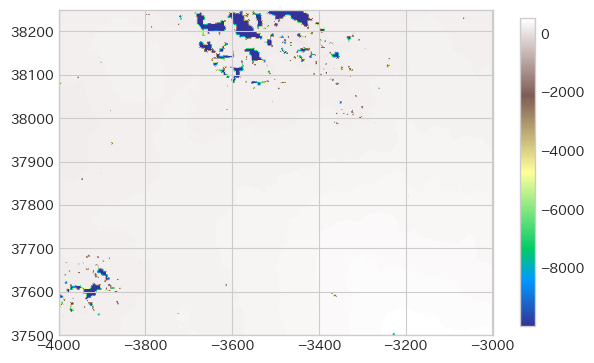

In [5]:
# 'read'では'indexes'で確認した番号を指定します。
dtm = dst.read(indexes=1)

# 描画の範囲をmatplotlibのlimに適用させる
plt.figure(figsize=(7, 5))
extent = (dst.bounds.left, dst.bounds.right, dst.bounds.bottom, dst.bounds.top)
plt.imshow(dtm, extent=extent, cmap='terrain')
plt.colorbar(shrink=0.8);

欠損値が邪魔して綺麗に可視化されていません。メタデータ確認時に見ていた通り欠損値には '-9999' が入力されているので、可視化する値の範囲に制限を掛けます。

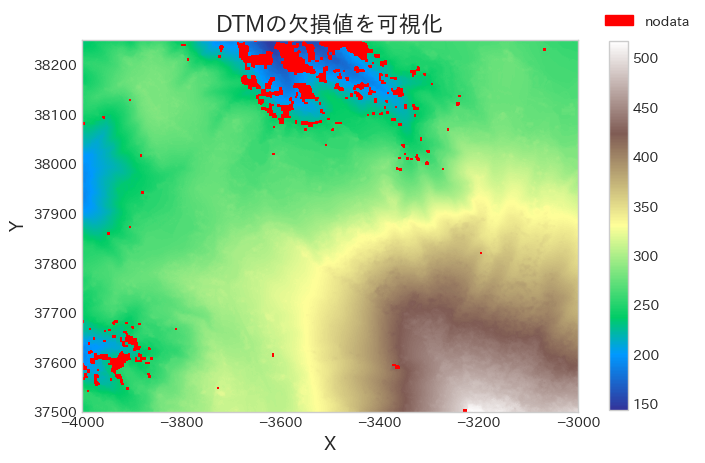

In [6]:
fig = plt.figure(figsize=(8, 6))

# 欠損値を赤色で目立たせる
nodata = np.zeros(dtm.shape)
nodata[:, :] = 255
plt.imshow(nodata, cmap='bwr_r', extent=extent)
patches = [matplotlib.patches.Patch(color='red', label="nodata")]
plt.legend(handles=patches, bbox_to_anchor=(1.25, 1.1))

# DTMの可視化
dtm_nan = np.where(dtm < 0, np.nan, dtm)
_cb = plt.imshow(
    X=dtm_nan, 
    cmap='terrain',
    extent=extent
)
fig.colorbar(_cb, shrink=0.8)
plt.title('DTMの欠損値を可視化', fontsize=16)
plt.xlabel('X', fontsize=13)
plt.ylabel('Y', fontsize=13)
plt.grid(False);

colorbar が不要な場合は `rasterio.plot.show` を使用する事で、欠損値の処理や範囲指定をする必要がないので楽です。

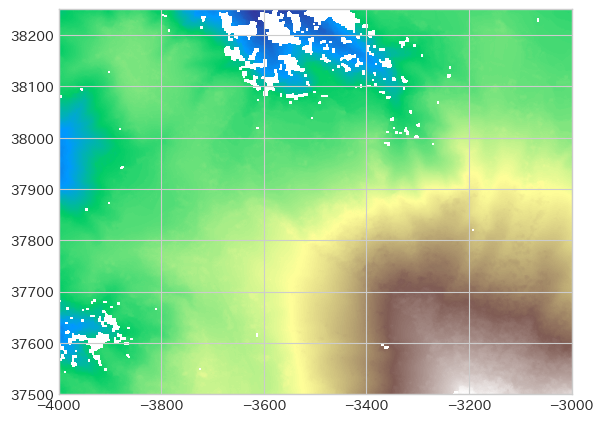

In [7]:
plt.figure(figsize=(7, 5))
rasterio.plot.show(dst, cmap='terrain');

## **穴埋め（欠損値補完）**
---
rasterio には 'rasterio.fill.fillnodata' というメソッドが用意されており、簡単に欠損値の処理を行う事ができます。これには 'mask'として、同じ形状の配列を渡す必要があります。mask 配列は **"欠損値がある場所を 0 それ以外には 255"** を入力したものが必要です。ただし、別に自分で作成しなくとも 'DatasetReader.read_masks' で取得する事が可能です。

単純にこれを実行すると、元の 'dtm_ary' にも穴埋めが適用されるので（参照渡し）、copy をして元データを変更しない様にします。

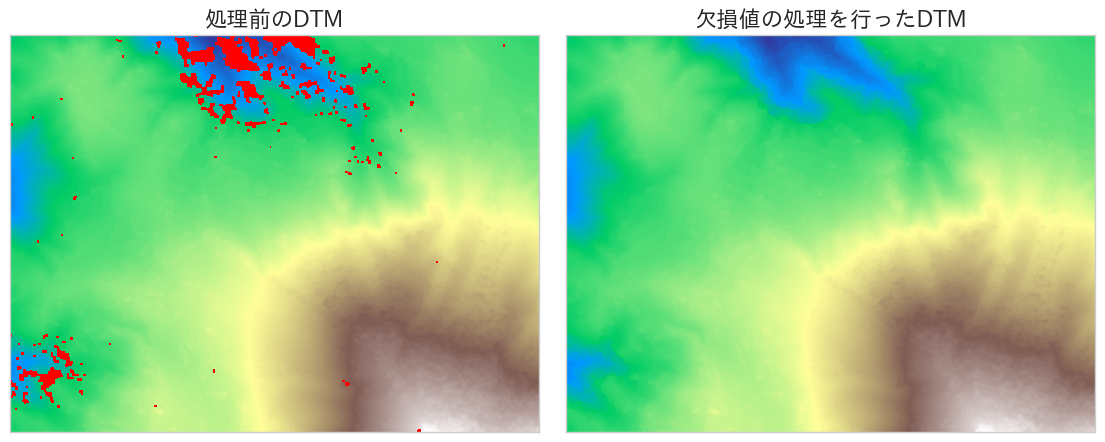

In [8]:
# 欠損値の穴埋め
dtm_fill = rasterio.fill.fillnodata(
    # DTMの行列をCopyして渡す
    image=dtm.copy(),
    mask=dst.read_masks(1),
    # 補完する場合にどこまで離れたセルまで検索するか。デフォルトが100です。
    max_search_distance=100,
)


# 可視化
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))
arys = [dtm_nan, dtm_fill]
titles = ['処理前のDTM', '欠損値の処理を行ったDTM']
for _ax, ary, title in zip(ax, arys, titles):
    _ax.imshow(nodata, cmap='bwr_r')
    _ax.imshow(ary, cmap='terrain')
    _ax.set_title(title, fontsize=16)
    _ax.grid(False)
    _ax.axes.xaxis.set_visible(False)
    _ax.axes.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0.05);

## **データの保存**
---
欠損値を処理する事が出来たので、一度この配列を Raster として保存しましょう。

rasterio では普通に画像として保存する事も当然できますが、今の状況の様に Notebook でデータを見ながら実行している場合は、一々データを出力していてはディレクトリの中が汚くなってしまいます。rasterio ではインメモリに保存することも可能なので、今回はその方法を試してみます。

In [9]:
# インメモリにRasterを作成する
dst_fill = rasterio.MemoryFile().open(**dst.meta)
# インメモリのRasterに穴埋めしたDTMを書き込む
dst_fill.write(dtm_fill, 1)

pprint(raster_metadata(dst_fill))

{'area': 750875.25,
 'bounds': BoundingBox(left=-4000.0, bottom=37500.0, right=-2999.5, top=38250.5),
 'cells': 3003501,
 'data_type': ('float64',),
 'epsg': 6669,
 'height': 1501,
 'indexes': (1,),
 'nodata': -9999.0,
 'nodata_cells': 0,
 'nodata_ratio': 0.0,
 'resolution': 0.5,
 'shape': (1501, 2001),
 'stats': Statistics(min=143.0800018310547, max=516.9000244140625, mean=301.83231935691396, std=67.80678643427129),
 'type': <class 'rasterio.io.DatasetWriter'>,
 'width': 2001,
 'x_length': 750.5,
 'y_length': 1000.5}


## **DTMの平滑化**
---
DTMの平滑化を行う前に、何故わざわざ今ある情報を消すような事（平滑化）をするのか。実際に穴埋めした DTM を拡大して見てみましょう。

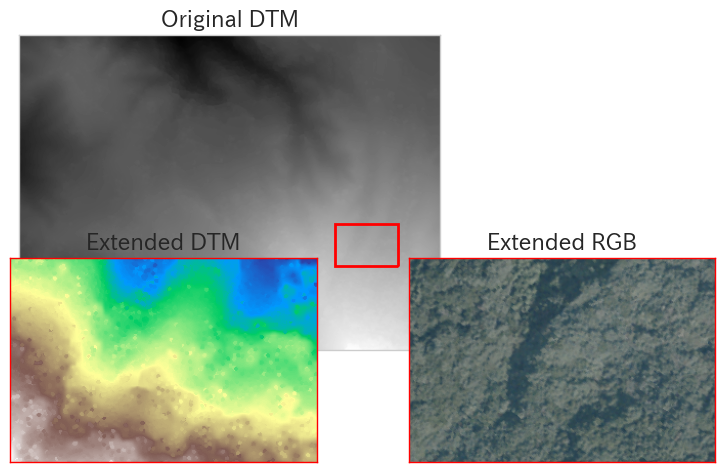

In [107]:
# RGB画像を読み込む
dst_rgb = rasterio.open(FILE_PATH_RGB)
# 拡大する範囲指定
extended_scope = shapely.box(-3250, 37700, -3100, 37800)

# オリジナルのDTMを可視化
fig = plt.figure(figsize=(10, 7))
shape = (5, 6)
ax1 = plt.subplot2grid(shape, loc=(0, 0), rowspan=3, colspan=4)
ax1.imshow(dtm_fill, cmap='gray', extent=extent)
plot_polygon(
    extended_scope, 
    ax=ax1, 
    color='red', 
    facecolor=(0, 0, 0, 0), 
    linewidth=2, 
    add_points=False
)
# 拡大したDTMを可視化
ax2 = plt.subplot2grid(shape, loc=(2, 0), rowspan=2, colspan=3)
extended_dtm = rasterio.mask.mask(dst_fill, shapes=[extended_scope], crop=True)[0][0]
ax2.imshow(extended_dtm, cmap='terrain')
# 拡大したRGB画像を可視化
ax3 = plt.subplot2grid(shape, loc=(2, 3), rowspan=2, colspan=3)
extended_rgb = rasterio.mask.mask(dst_rgb, shapes=[extended_scope], crop=True)[0]
ax3.imshow(np.dstack(extended_rgb), cmap='terrain')
# 各種設定
titles = ['Original DTM', 'Extended DTM', 'Extended RGB']
for i, (_ax, title) in enumerate(zip(fig.axes, titles)):
    _ax.set_title(title, fontsize=16)
    _ax.grid(False)
    _ax.axes.xaxis.set_visible(False)
    _ax.axes.yaxis.set_visible(False)
    if 0 < i:
        for children in _ax.get_children():
            if isinstance(children, Spine):
                children.set_color('red')

拡大すると丸い粒のようなものが沢山確認できます。本当にこの様な地形なのでしょうか?

RGB画像を画像を見るとわかる様に、この拡大している場所は森林です。恐らくこれらは地表付近の下層植生（低木やシダ類など）が DTM の計算に含まれてしまったからだと思えます。出来ればこれらを処理して取り除き、なるべく滑らかに、元の情報を消さずに新たな DTM を作成したいです。

### **sample の確認**
RasterData から座標を指定してサンプルを取得します。

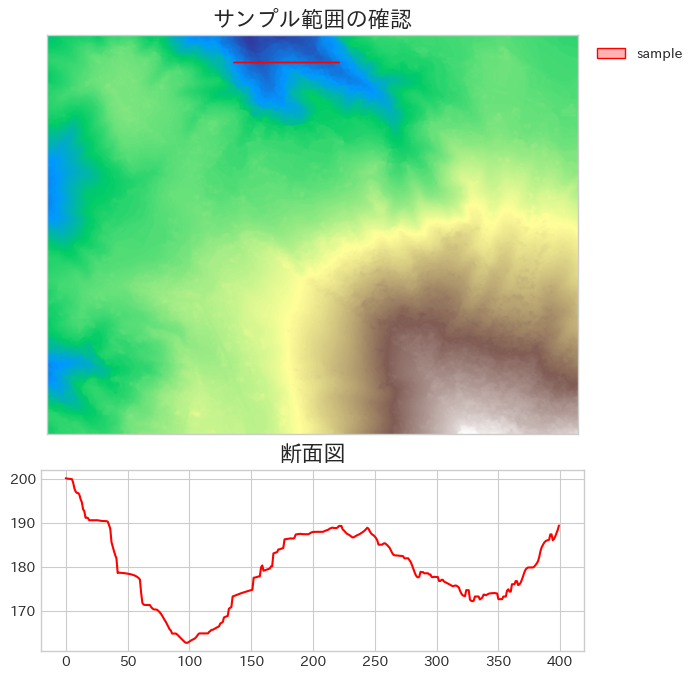

In [108]:
def crop_raster(dst, scope):
    return rasterio.mask.mask(dst, shapes=[scope], crop=True)[0][0][0]

crop_scope = shapely.box(-3650, 38200, -3450, 38200.5)
fig = plt.figure(figsize=(7, 8))

# DTMの可視化
shape = (3, 1)
ax1 = plt.subplot2grid(shape, loc=(0, 0), rowspan=2)
ax1.imshow(dtm_fill, cmap='terrain', extent=extent)
plot_polygon(crop_scope, ax=ax1, color='red', add_points=False, label='sample')
ax1.grid(False)
ax1.set_title('サンプル範囲の確認', fontsize=16)
ax1.legend(bbox_to_anchor=(1.22, 1))
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)

# サンプル範囲の可視化
ax2 = plt.subplot2grid(shape, loc=(2, 0), rowspan=1)
ori_cs = crop_raster(dst_fill, crop_scope)
ax2.plot(ori_cs, c='red', label='terrain');
ax2.set_title('断面図', fontsize=16);

### **畳み込みで滑らかにする**

DTM に対して畳み込みを行う事で、近傍のセルの平均を計算して滑らかな DTM を作成する事が出来ます。

対象とするセルを含む25個のセルで畳み込みを行って結果を見てみましょう

In [116]:
def convolution_kernel(distance):
    if distance % 2 == 0:
        distance += 1
    shape = (distance, distance)
    cells = distance * distance
    return np.ones(shape) / cells


# 25個のセルで平均化
rows = 5
dtm_conv_5 = (
    scipy
    .signal
    .convolve2d(dtm_fill, convolution_kernel(rows), mode='same')
)
dst_conv_5 = rasterio.MemoryFile().open(**dst.meta)
dst_conv_5.write(dtm_conv_5, 1)
crop_conv_5 = crop_raster(dst_conv_5, crop_scope)

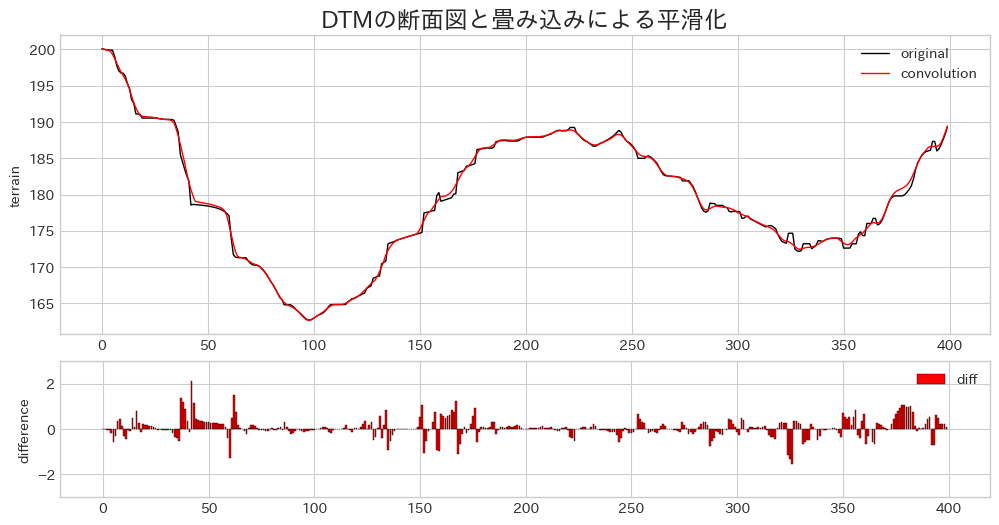

In [143]:
fig = plt.figure(figsize=(12, 6))
shape = (3, 1)
# 横断図の可視化
ax1 = plt.subplot2grid(shape, loc=(0, 0), rowspan=2)
idx = np.arange(0, len(ori_cs))
ax1.plot(ori_cs, lw=1, c='black', zorder=1, label='original')
ax1.plot(crop_conv_5, c='red', lw=1, zorder=2, label='convolution')
ax1.set_title('DTMの断面図と畳み込みによる平滑化', fontsize=17)

# オリジナルデータと平滑化後の差分を可視化
ax2 = plt.subplot2grid(shape, loc=(2, 0))
x_idx = np.arange(0, len(crop_conv_5))
ax2.bar(x_idx, crop_conv_5 - ori_cs, facecolor='red', edgecolor='black', lw=0.3, label='diff')
ax2.set_ylim(-3, 3)

for _ax, ylabel in zip(fig.axes, ['terrain', 'difference']):
    _ax.set_ylabel(ylabel)
    _ax.legend()
plt.show()

### **ガウシアンフィルターを使用した平滑化**
ガウシアンフィルターは、画像処理において平滑化を目的として使用されるフィルタの一種です。ガウシアンフィルターは対象とするセルとの距離に応じて重みづけを行う為、自然な平滑化を行う事が出来ます。

In [167]:
###d

dtm_gauss = (
    ndimage
    .gaussian_filter(
        dtm_fill, 
        sigma=2, 
        mode='constant', 
        truncate=4
    )
)
dst_gauss = rasterio.MemoryFile().open(**dst.meta)
dst_gauss.write(dtm_gauss, 1)
crop_gauss = crop_raster(dst_gauss, crop_scope)

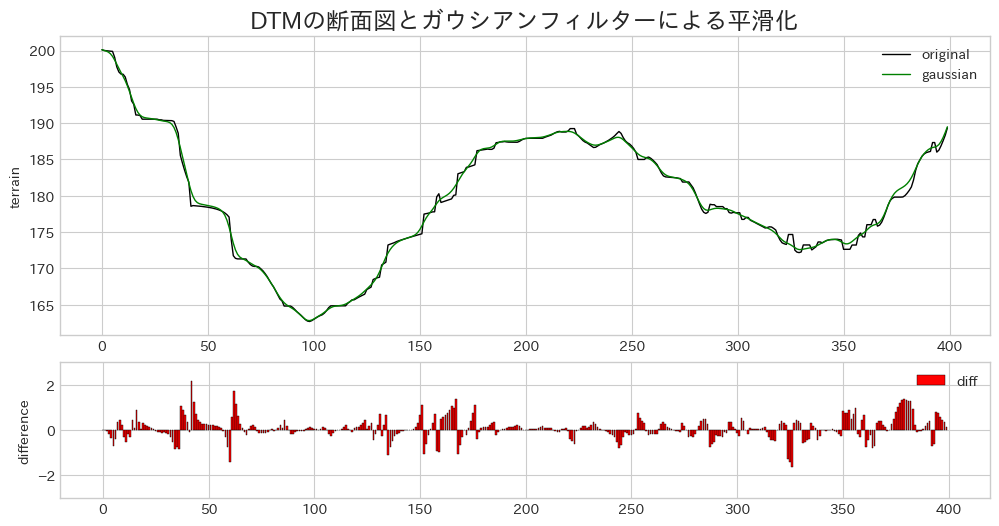

In [187]:
fig = plt.figure(figsize=(12, 6))
shape = (3, 1)
# 横断図の可視化
ax1 = plt.subplot2grid(shape, loc=(0, 0), rowspan=2)
idx = np.arange(0, len(ori_cs))
ax1.plot(ori_cs, lw=1, c='black', zorder=1, label='original')
ax1.plot(crop_gauss, c='green', lw=1, zorder=3, label='gaussian')
ax1.set_title('DTMの断面図とガウシアンフィルターによる平滑化', fontsize=17)

# オリジナルデータと平滑化後の差分を可視化
ax2 = plt.subplot2grid(shape, loc=(2, 0))
ax2.bar(x_idx, crop_gauss - ori_cs, facecolor='red', 
        edgecolor='black', lw=0.3, label='diff')
ax2.set_ylim(-3, 3)

for _ax, ylabel in zip(fig.axes, ['terrain', 'difference']):
    _ax.set_ylabel(ylabel)
    _ax.legend()
plt.show()

畳み込みよりもガウシアンフィルターの方が少し滑らかになった様に見えます。

### **畳み込みの繰り返し**

当然ですが、ただ単に滑らかにしたいだけであれば、畳み込みを繰り返すだけで滑らかなデータを作成できます。しかし滑らかにしすぎると、窪地などの地形の情報が消えてしまうので注意が必要です。

In [184]:
def multi_conv(ary_2d, start_distance, count):
    for _ in range(count):
        ary_2d = scipy.signal.convolve2d(
            ary_2d, convolution_kernel(start_distance), mode='same')
        start_distance += 2
    return ary_2d

dtm_gauss_m = multi_conv(dtm_fill, 3, 5)
dst_gauss_m = rasterio.MemoryFile().open(**dst.meta)
dst_gauss_m.write(dtm_gauss_m, 1)
crop_gauss_m = crop_raster(dst_gauss_m, crop_scope)

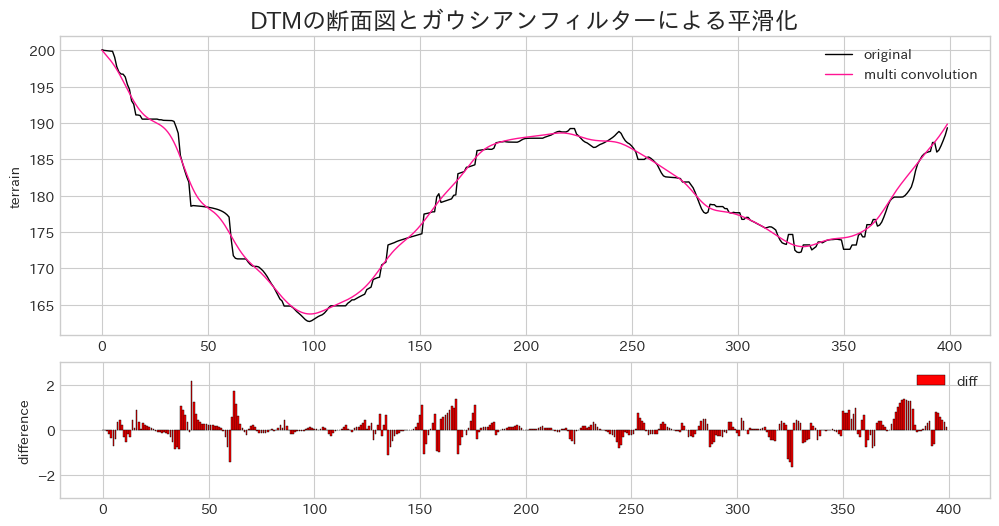

In [188]:
fig = plt.figure(figsize=(12, 6))
shape = (3, 1)
# 横断図の可視化
ax1 = plt.subplot2grid(shape, loc=(0, 0), rowspan=2)
idx = np.arange(0, len(ori_cs))
ax1.plot(ori_cs, lw=1, c='black', zorder=1, label='original')
ax1.plot(crop_gauss_m, c='deeppink', lw=1, zorder=3, label='multi convolution')
ax1.set_title('DTMの断面図とガウシアンフィルターによる平滑化', fontsize=17)

# オリジナルデータと平滑化後の差分を可視化
ax2 = plt.subplot2grid(shape, loc=(2, 0))
ax2.bar(x_idx, crop_gauss - ori_cs, facecolor='red', 
        edgecolor='black', lw=0.3, label='diff')
ax2.set_ylim(-3, 3)

for _ax, ylabel in zip(fig.axes, ['terrain', 'difference']):
    _ax.set_ylabel(ylabel)
    _ax.legend()
plt.show()

### **下層植生が非常に多い場合**
※以下の方法は
基本的にはガウシアンフィルターを一度通すだけで、データが滑らかになるのでそれで問題ないと思います。しかし下層植生が非常に多い場合はそうはいきません。

In [ ]:
### 

畳み込みをすればする程に地形は滑らかになりますが、谷の部分を見るとわかりやすい様に、高さが上昇してしまっています。

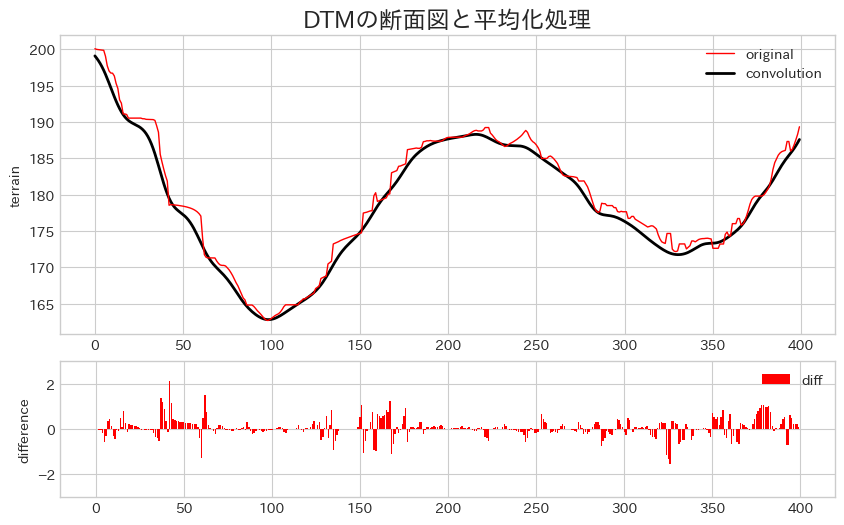

In [73]:
rows = 3
dtm_blur = scipy.signal.convolve2d(dtm_fill, mean_tensor(rows), mode='same')
for i in range(5):
    rows += 2
    dtm_blur_5 = scipy.signal.convolve2d(dtm_blur_5, mean_tensor(rows), mode='same')


dtm_min = ndimage.minimum_filter(dtm_fill, 5, mode='constant')
rows = 3
for i in range(2):
    dtm_min = ndimage.minimum_filter(dtm_min, rows, mode='constant')
    dtm_min = scipy.signal.convolve2d(dtm_min, mean_tensor(rows), mode='same')


dtm_min_filter = (dtm_blur + dtm_min) / 2
rows = 3
for i in range(3):
    rows += 2
    dtm_min_filter = scipy.signal.convolve2d(
        dtm_min_filter, mean_tensor(rows), mode='same')
dst_blur_5 = rasterio.MemoryFile().open(**dst.meta)
dst_blur_5.write(dtm_min_filter, 1)


fig = plt.figure(figsize=(10, 6))
shape = (3, 1)
ax1 = plt.subplot2grid(shape, loc=(0, 0), rowspan=2)
idx = np.arange(0, len(ori_cs))
ax1.plot(ori_cs, lw=1, c='red', zorder=2, label='original')
crop_min = crop_raster(dst_blur_5, scope)
ax1.plot(crop_min, c='black', lw=2, zorder=1, label='convolution')
ax1.set_title('DTMの断面図と平均化処理', fontsize=17)


ax2 = plt.subplot2grid(shape, loc=(2, 0))
ax2.bar(np.arange(0, len(crop_blur_5)), crop_blur_5 - ori_cs, 
        facecolor='red', label='diff')
ax2.set_ylim(-3, 3)
for _ax, ylabel in zip(fig.axes, ['terrain', 'difference']):
    # _ax.axes.xaxis.set_visible(False)
    _ax.set_ylabel(ylabel)
    _ax.legend()
plt.show()


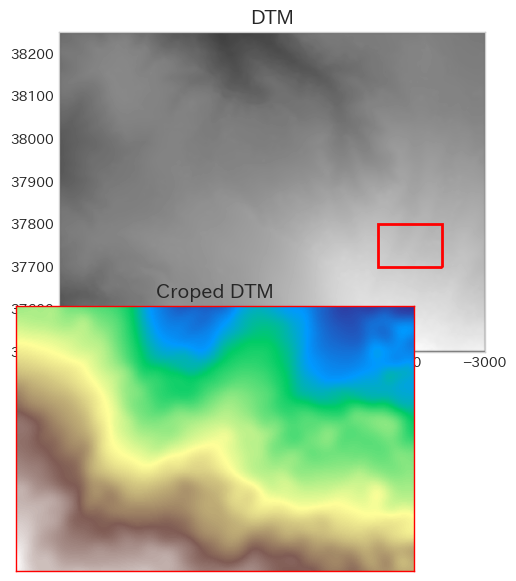

In [74]:
scope_ = shapely.box(-3250, 37700, -3100, 37800)
shape = (10, 7)
fig = plt.figure(figsize=shape)
ax1 = plt.subplot2grid(shape, loc=(0, 0), colspan=6, rowspan=6)
ax1.imshow(dtm_min_filter, cmap='gray', extent=extent)
plot_polygon(scope_, ax=ax1, 
             color='red', facecolor=(0, 0, 0, 0), 
             linewidth=2, add_points=False
)

ax2 = plt.subplot2grid(shape, loc=(5, 0), colspan=5, rowspan=5)
img = rasterio.mask.mask(dst_blur_5, shapes=[scope_], crop=True)[0][0]
ax2.imshow(img, cmap='terrain')
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)

for _ax, title in zip(fig.axes, ['DTM', 'Croped DTM']):
    _ax.grid(False)
    _ax.set_title(title, fontsize=14)

for children in ax2.get_children():
    if isinstance(children, Spine):
        children.set_color('red')

In [237]:
import pandas as pd

series = ori_cs.copy()
index = np.arange(0, len(ori_cs))

_s = pd.Series(series)
mins = _s.rolling(10, center=True, min_periods=1).min()
means = mins.rolling(10, center=True, min_periods=1).mean()

In [238]:
ter2 = \
    pd.Series((ori_cs + means) / 2)\
    .rolling(20, center=True, min_periods=1).mean()

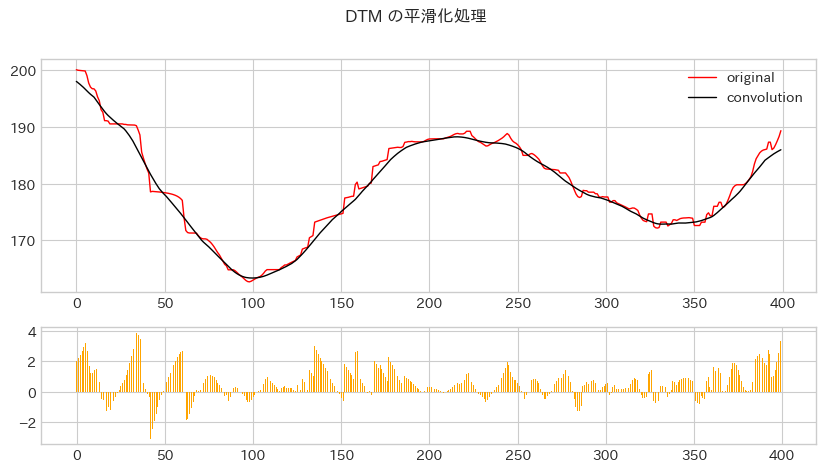

In [243]:
fig, ax = plt.subplots(nrows=2,figsize=(10, 5), gridspec_kw=dict(height_ratios=[2, 1]))
ax[0].plot(series, c='red', lw=1, label='original')
ax[0].plot(ter2, c='black', lw=1, label='convolution')
ax[0].legend()
ax[1].bar(index, series - ter2, width=0.5, color='orange')
plt.suptitle('DTM の平滑化処理');